In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf


In [2]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from IPython.display import clear_output

In [3]:
dim = 30

In [4]:
def plotVoxels(vertices):
    fig = plt.figure(figsize=(9,9))
    ax = fig.gca(projection='3d')
    ax.voxels(vertices,edgecolor='k')
    ax.set_aspect('equal')

    plt.show()
def saveVoxels(dir_name, vox):
    with open(dir_name, 'w') as file:
        for i in range(dim):
            for j in range(dim):
                for k in range(dim):
                    file.write(str(int(vox[i][j][k])))
                    if k == dim - 1:
                        file.write("\n")
                    else:
                        file.write(',')
def loadVoxels(dir_name):
    voxels = np.zeros((dim,dim,dim))
    with open(dir_name) as file:
        for i in range(dim):
            for j in range(dim):
                line = file.readline()
                if line != "":
                    l = np.array(line.split(",")).astype(int)
                    voxels[i][j] = l
    return voxels        

In [5]:
train_models = []
for filename in os.listdir('ChairVoxels\\train\\'):
    v = loadVoxels(os.getcwd() + '\\ChairVoxels\\train\\' + filename)
    train_models.append(v)
    clear_output()
    print(filename)
train_models = np.array(train_models)
train_labels = np.ones(train_models.shape[0])
print(train_models.shape)
print(train_labels.shape)


char_0551.vox
(890, 30, 30, 30)
(890,)


In [6]:
train_models = train_models.reshape(train_models.shape[0], 30, 30, 30, 1).astype('float32')
print(train_models.shape)

(890, 30, 30, 30, 1)


In [7]:
BUFFER_SIZE = 890
BATCH_SIZE = 10

In [8]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_models).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [9]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(5*5*5*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((5, 5,5, 256)))
    assert model.output_shape == (None, 5, 5,5, 256) # Note: None is the batch size

    model.add(layers.Conv3DTranspose(128, (5, 5, 5), strides=(1, 1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 5, 5,5, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv3DTranspose(64, (5, 5, 5), strides=(3, 3, 3), padding='same', use_bias=False))
    assert model.output_shape == (None, 15, 15,15, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv3DTranspose(1, (5, 5, 5), strides=(2, 2, 2), padding='same', use_bias=False, activation='sigmoid'))
    assert model.output_shape == (None, 30, 30, 30, 1)

    return model

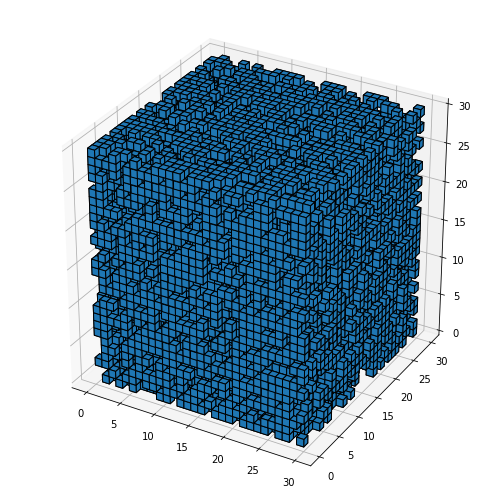

In [10]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_model = generator(noise, training=False)
vox = np.array(generated_model).reshape((30,30,30)).round()
plotVoxels(vox)

In [11]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv3D(64, (5, 5, 5), strides=(2, 2, 2), padding='same',
                                     input_shape=[30, 30, 30, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv3D(128, (5, 5, 5), strides=(2, 2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [12]:
discriminator = make_discriminator_model()
decision = discriminator(generated_model)
print (decision)

tf.Tensor([[-0.06374148]], shape=(1, 1), dtype=float32)


In [13]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [14]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [15]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [17]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [18]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 1

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [19]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [31]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)
    
    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    clear_output()
    generate_and_save_images(generator, seed)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  generate_and_save_images(generator, seed)

In [40]:
def generate_and_save_images(model, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)


  for i in range(predictions.shape[0]):
    vox = np.array(predictions[i]).reshape((30,30,30)).round()
    plotVoxels(vox)
    
  

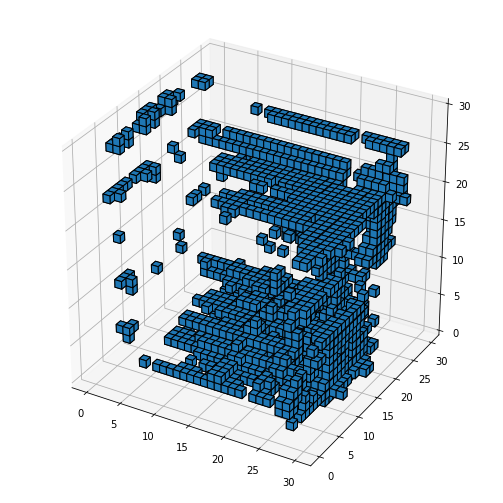

Time for epoch 36 is 146.7531876564026 sec


KeyboardInterrupt: 

In [42]:
train(train_dataset, EPOCHS)

In [43]:
checkpoint.save(file_prefix = checkpoint_prefix)

'./training_checkpoints\\ckpt-4'

In [24]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

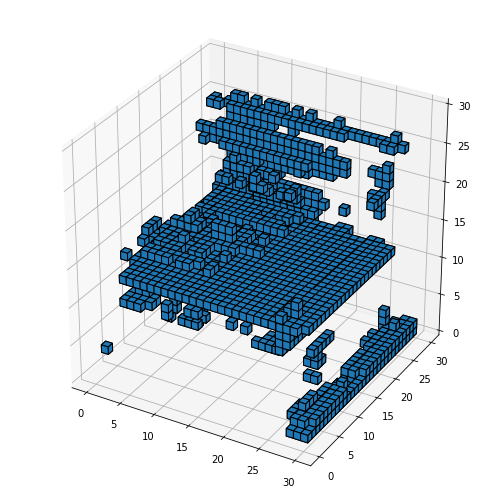

In [76]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])
generate_and_save_images(generator, seed)